In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import gensim
import pandas as pd
import json

In [ ]:
website_text_df = pd.read_csv('../input/hackrx-20-bajaj-fin-serv/paras-and-lines-website-scraped.csv')
website_text_df

# Training our Word2Vec Embeddings

We are training domain specific word embeddings using Gensim Library. 

Concept of word embeddings can be understood using this [Youtube Video by Codebasics](https://www.youtube.com/watch?v=hQwFeIupNP0&t=2s) 

We used [Jupyter Notebook](https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/42_word2vec_gensim/42_word2vec_gensim.ipynb) and [Youtube Video by Codebasics](https://www.youtube.com/watch?v=Q2NtCcqmIww&t=3s) to understand how to train our own word embeddings

In [ ]:
#Preprocessing the text obtained from scraping to convert them to tokens
website_text = website_text_df['lines'].apply(gensim.utils.simple_preprocess)
website_text

In [ ]:
#Initializing the model
model = gensim.models.Word2Vec(
    window=10,   # window size, number of words that'll be in the window at once
    min_count=2, # minimum number of words in a line for it to be considered
    workers=4,   # worker threads to concurrently train the model [keep at no. of cores - 1]
)

In [ ]:
#Building vocabulary for the model
model.build_vocab(website_text, progress_per=1000)

In [ ]:
model.epochs = 50
print(model.epochs, model.corpus_count)

In [ ]:
%%time
#Training the word2vec model
model.train(website_text, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
model.save("./word2vec-only-website-data.model")

In [ ]:
#Checking model performance
model.wv.most_similar('loan')

In [ ]:
model.wv.most_similar('insurance')

In [ ]:
model.wv.most_similar('demat')

# Improving the word embeddings model with more data from Twitter

We also scraped all the tweets from Bajaj Finserv Twitter Handle and improved our word embeddings model using those tweets. 

In [ ]:
tweets_df = pd.read_csv('/kaggle/input/hackrx-20-bajaj-fin-serv/tweets-extracted-from-bajaj-finserv-twitter.csv')
tweets_df

In [ ]:
!pip3 install tweet-preprocessor

In [ ]:
import preprocessor as p
import re
tweet_text_cleaned = tweets_df.Text.apply(p.clean)
tweet_text_cleaned = tweet_text_cleaned.apply(lambda x: re.sub(r"www\S+", "", x))
tweet_text_preprocessed = tweet_text_cleaned.apply(gensim.utils.simple_preprocess)
tweet_text_preprocessed

In [ ]:
website_and_twitter_text = website_text
website_and_twitter_text = website_and_twitter_text.append(tweet_text_preprocessed)

In [ ]:
#Initializing the model
model = gensim.models.Word2Vec(
    window=10,   # window size, number of words that'll be in the window at once
    min_count=2, # minimum number of words in a line for it to be considered
    workers=4,   # worker threads to concurrently train the model [keep at no. of cores - 1]
)

In [ ]:
model.build_vocab(website_and_twitter_text)

In [ ]:
%%time
model.train(website_and_twitter_text, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
model.save('./word2vec-website-and-twitter-data.model')

In [ ]:
model.wv.most_similar('loan')

In [ ]:
model.wv.most_similar('insurance')

In [ ]:
model.wv.most_similar('demat')

# Using the model to recommend relavant articles

We decided to use the headings of the articles that we smartly got from the url of the article to find out which articles should be suggested when a user searches for some keyword 

In [ ]:
urls_df = pd.read_csv('/kaggle/input/hackrx-20-bajaj-fin-serv/webpage-urls-to-recommend-from.csv')
urls_df

In [ ]:
links = urls_df['links']

In [ ]:
# model = gensim.models.Word2Vec.load('./word2vec-website-and-twitter-data.model')

# Building A Benchmark - Regular Expression-based Search Engine

In [ ]:
def gen_results_regex(queries, links):
    results = {}
  
    for query in queries:
        if type(query) == list: 
            query = '-'.join(query)
    
        results[query] = {}
        
        ranked_list = []

        for link in links:
            link_score = 0
            for w in query.split('-'):
                if link.find(w) != -1:
                    link_score += 1
            # link score is incremented for every word 
            # in query that's also in the link

            if link_score > 0:
                if link_score not in results[query].keys():
                    results[query][link_score] = []
                results[query][link_score].append(link)

        # in the ranked list, show the links with the highest score
        for i in sorted(results[query].keys(), reverse = True):
            ranked_list += results[query][i]
        
        results[query] = ranked_list
        
    regex_results_df = {'link': list(links)}

  # doing one hot encoding
    for query in results.keys():
        one_hot_encoded_values = []
        for link in links:
            value = 0
            if link in results[query]:
                value = 1
            one_hot_encoded_values.append(value)
            
        regex_results_df[query] = one_hot_encoded_values

    regex_results_df = pd.DataFrame(regex_results_df)
    return regex_results_df

# Building Another Benchmark - Using GLoVE Embeddings

In [ ]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-100") 

In [ ]:
def process_query(wv, query, min_threshold = 0.3, max_threshold = 0.4, viewResults = True):
    results = {}
    stop_words = ['and', 'to', 'for', 'on', 'us', 'of']
    for l in links:
        lw = [w for w in l.split('/')[-1].lower().split('-') if (w not in stop_words)]
        qw = [w for w in query.split(' ') if (w not in stop_words)]
        similarities = []
    
        for q_w in qw:
            word = ''
            simi = -100000
            for w in lw:
                if w in wv.key_to_index and q_w in wv.key_to_index:
                # simi = max(simi, wv.similarity(w, q_w))
                    if simi < wv.similarity(w, q_w):
                        simi = wv.similarity(w, q_w)
                        word = 'Word in link: {0} | Word in query: {1} --- Link: '.format(q_w, w)

        similarities.append(simi)
    
        if min(similarities) > min_threshold and max(similarities) > max_threshold:
            results[l] = max(similarities)
            if viewResults: print('Similarity: {0} | '.format(results[l]) + word + l)
  
    results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse = True)}
    return results

In [ ]:
def gen_results_glove(queries, links, min_threshold=0.3, max_threshold=0.4, viewResults = True):
    q_df = {'link': links}
    for q in queries:
        q_df[q] = []
        results = process_query(word_vectors, q, min_threshold, max_threshold, viewResults)
        for l in links:
            val = 0
            if l in results.keys():
                val = 1
            q_df[q].append(val)
    q_df = pd.DataFrame(q_df)
    return q_df

# Our simple Embedding Model

In [ ]:
model = gensim.models.Word2Vec.load('./word2vec-website-and-twitter-data.model')

In [ ]:
def gen_results_ourWE(queries, links, min_threshold=0.3, max_threshold=0.4, viewResults = True):
    q_df = {'link': links}
    for q in queries:
        q_df[q] = []
        results = process_query(model.wv, q, min_threshold, max_threshold, viewResults)
        for l in links:
            val = 0
            if l.split()[-1] in results.keys():
                val = 1
            q_df[q].append(val)
  
    q_df = pd.DataFrame(q_df)
    return q_df

# Calculating Precision and Recall Scores

In [ ]:
def calculate_precision_and_recall(seriesGold, seriesMarked):
    gold = list(seriesGold)
    marked = list(seriesMarked)

    true_positive, false_positive = 0, 0
    true_negative, false_negative = 0, 0

    for i, j in zip(gold, marked):
        if i==j:
            if i == 0:
                true_negative += 1
            else:
                true_positive += 1
        else:
            if i == 1:
                false_negative += 1
            else:
                false_positive += 1
  
    precision, recall = 0, 0
  
    if true_positive + false_positive != 0:
        precision = true_positive / (true_positive + false_positive)
  
    if true_positive + false_negative != 0:
        recall    = true_positive / (true_positive + false_negative)

    return precision, recall

In [ ]:
def calculate_precision_and_recall_wrapper(goldSearch, df, queries):
    precisions, recalls = [], []
    for q in queries:
        precision, recall = calculate_precision_and_recall(goldSearch[q], df[q])
        precisions.append(precision)
        recalls.append(recall)
  
    len_precisions = sum([1 for i in precisions if i!=0])
    len_recalls    = sum([1 for i in recalls if i!=0])

    print('Precision:', sum(precisions)/len_precisions)
    print('Recall:',    sum(recalls)/len_recalls)

# Comparing Results On Manually Annotated Queries

In [ ]:
gold = pd.read_csv('../input/hackrx-20-bajaj-fin-serv/gold-standard-queries-and-results.csv')
gold

In [ ]:
links = gold['Link']
queries = list(gold.columns)[1:]

## Regex Model Scores

In [ ]:
regex_df = gen_results_regex(queries, links)
regex_df.to_csv('regex-model-search-one-hot-encoded-results.csv', index=False)
print('--------------------------------P&R--------------------------------')
print('Precision and Recall for Regex Model')
calculate_precision_and_recall_wrapper(gold, regex_df, queries)

In [ ]:
# set viewResults to True to see results and analyses for each query and each link
glove_df = gen_results_glove(queries, links, min_threshold=0.3, max_threshold=0.4, viewResults = False)
glove_df.to_csv('./glove-model-search-one-hot-encoded-results.csv', index=False)
print('--------------------------------P&R--------------------------------')
print('Precision and Recall for GLoVE Model')
calculate_precision_and_recall_wrapper(gold, glove_df, queries)

In [ ]:
# set viewResults to True to see results and analyses for each query and each link
ourWE_df = gen_results_ourWE(queries, links, min_threshold=0.3, max_threshold=0.4, viewResults = True)
ourWE_df.to_csv('./our-embedding-model-search-results.csv', index=False)
print('--------------------------------P&R--------------------------------')
print("Precision and Recall for Our Embeddings' Model")
calculate_precision_and_recall_wrapper(gold, ourWE_df, queries)

# What are you waiting for? 

# Fork this notebook and get better results than us
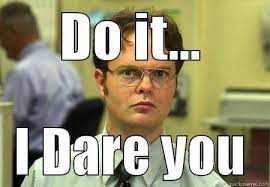

# Let us know how you did in the comments ;)